# 🎵 Concert Enjoyment Classification – Model Training & Evaluation
## Objective
This notebook focuses on model development, training, and evaluation for the concert enjoyment classification task.
Building on the insights obtained during exploratory data analysis, the goal is to design and evaluate models that accurately predict concert enjoyment levels while respecting their ordinal structure.

## Problem Framing
The target variable represents ordered levels of enjoyment, ranging from Worst Concert Ever to Best Concert Ever.
Rather than treating this task as a standard multi-class classification problem, the modeling strategy explicitly accounts for the ordinal nature of the labels, where prediction errors closer to the true class are less severe than distant ones.

## Modeling Strategy
The notebook explores and compares multiple modeling approaches, with a primary focus on deep learning–based ordinal classification. The modeling pipeline includes:
- Feature preprocessing and encoding
- Train / validation split
- Deep learning model design tailored to ordinal targets
- Hyperparameter tuning and regularization
- Model selection based on validation performance

## Evaluation Criteria
Model performance is assessed using metrics appropriate for ordinal prediction, including:
- Mean Absolute Error (MAE)
- Class-wise performance analysis
- Confusion matrices interpreted with respect to label ordering
These metrics allow for a more nuanced evaluation than standard accuracy, reflecting the relative severity of prediction errors.

## Outcome
The objective is to identify a model that provides the best trade-off between predictive performance, robustness, and respect for the ordinal structure, and to justify the final model choice based on empirical results.

## 0. Installations and Imports

In [ ]:
# installations
# !pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install sklearn
#!pip install spacecutter
#!pip install skorch
#!pip install seaborn
#!pip install graphviz
#!pip install mord
#%pip install -U seaborn


In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from spacecutter.models import OrdinalLogisticModel

from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

from skorch import NeuralNet
from spacecutter.callbacks import AscensionCallback
from spacecutter.losses import CumulativeLinkLoss

plt.style.use('dark_background')
df = pd.read_csv("train.csv" )
df_test = pd.read_csv("test.csv" )

## 1.Data Preprocessing

In [6]:
numeric_cols = df.select_dtypes(include = np.number).columns.tolist()
categorical_cols = df.select_dtypes(["object" , "category"]).columns.tolist()
numeric_cols.remove('Concert ID')
categorical_cols.append('Concert ID') ## Concert ID is categorical
categorical_cols.append("Rain and not Inside Venue")
categorical_cols.remove("Id")
categorical_cols.remove("Concert Enjoyment")

### 1.1. Using known data to extrapolate the missing Data

Fill values of "Band Debut" , "Band Genre" and "Band Country Origin" from data already filled using the "Band Name" as index . For example , we already know that the debut of band "x" is 1995 . Same used for the rest of the Columns (Using one column to fill correlated Columns) . 

In [7]:
insert_cols = [ 'Band Name','Band Genre','Band Country of Origin','Concert Goer Country of Origin']
for df_ in [ df, df_test ]:
    for k in range(3):
        pi = df_.pivot_table(index = ["Concert ID","Band Name","Concert Attendance", "Inside Venue","Rain"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Band Name","Concert ID", "Inside Venue","Rain"]
        ind = "Concert Attendance"
        for col in columns :
            if col in insert_cols : 
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]


        pi = df_.pivot_table(index = ["Band Name","Band Debut", "Band Genre","Band Country of Origin"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Band Debut", "Band Genre","Band Country of Origin"]
        ind = "Band Name"
        for col in columns :
            if col in insert_cols   : 
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

        ## Same here , we can fill the values "Concert Attendance", "Inside Venue","Rain" from "Concert ID"
        pi = df_.pivot_table(index = ["Concert ID","Band Name","Concert Attendance", "Inside Venue","Rain"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Band Name","Concert Attendance", "Inside Venue","Rain"]
        ind = "Concert ID"
        for col in columns :
            if col in insert_cols : 
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

        ## Again ,same idea , "Concert Goer ID" gives us already ideas about "Concert Goer Age", "Height (cm)","Concert Goer Country of Origin" and the 4 Personality Traits .
        pi = df_.pivot_table(index = ["Concert Goer ID","Concert Goer Age", "Height (cm)","Concert Goer Country of Origin","Personnality Trait 1","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Concert Goer Age", "Height (cm)","Concert Goer Country of Origin","Personnality Trait 1","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]
        ind = "Concert Goer ID"
        for col in columns :
            if col in insert_cols :
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

        pi = df_.pivot_table(index = ["Concert Goer ID","Concert Goer Age", "Height (cm)","Concert Goer Country of Origin","Personnality Trait 1","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Concert Goer Age", "Height (cm)","Concert Goer Country of Origin","Concert Goer ID","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]
        ind = "Personnality Trait 1"
        for col in columns :
            if col in insert_cols :
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

        pi = df_.pivot_table(index = ["Concert Goer ID","Concert Goer Age", "Height (cm)","Concert Goer Country of Origin","Personnality Trait 1","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Concert Goer Age", "Height (cm)","Concert Goer Country of Origin","Concert Goer ID","Personnality Trait 1","Personnality Trait 3","Personnality Trait 4"]
        ind = "Personnality Trait 2"
        for col in columns :
            if col in insert_cols :
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

### 1.2 . Filling Concert ID and Concert Attendance 

Those are the only Columns we couldnt fill with the last approach , we can fill these columns thought by looking at their neighbors by Id , ConcertExperience_1 and ConcertExperience_2 ... all belong to same concert 

In [8]:
for df_ in [df , df_test ]:
    index_list = df_.loc[(df_["Concert ID"].isna())].index
    df_["new_Id"] = df_['Id'].str[18:].astype(int)
    for i in index_list : 
        prec = df_.iloc[i]["new_Id"]
        concert_id_list = df_[(df_["new_Id"] >= i-1 ) & (df_["new_Id"] <= i+1 ) ]["Concert ID"].tolist()
        concert_id = max(set(concert_id_list), key=concert_id_list.count)## get most freq elt 
        concert_attendance_list = df_[(df_["new_Id"] >= i-1 ) & (df_["new_Id"] <= i+1 ) ]["Concert Attendance"].tolist()
        concert_attendance = max(set(concert_attendance_list), key=concert_attendance_list.count) ## get most freq elt 
        df_.at[i , "Concert ID" ] = concert_id
        df_.at[i , "Concert Attendance" ] = concert_attendance
    df_.drop(columns = ["new_Id"] , inplace = True)

### 4.3. Fixing the outliers from Column "Trait Personnality 2" 

We have noticed from the analysis , that this Column "Trait Personnality 2" have a lot of outlier data , so here we fill it with median values 

In [9]:
for df_ in [df, df_test] :
    median = df_['Personnality Trait 2'].median()
    std = df_['Personnality Trait 2'].std()
    outliers = (df_['Personnality Trait 2'] - median).abs() > 5

    for i in df_[outliers].index : 
        df_.at[i , "Personnality Trait 2"] = median


The Only missing data we still have is from "Seated" Column , there is no way to extrapolate if a concert goer was seated in a concert or not 

In [10]:
df.fillna(value = {"Seated" : False} , inplace = True)
df_test.fillna(value = {"Seated" : False} , inplace = True)

/var/folders/zx/rhb75yw161jfg5wz76zyrm300000gp/T/ipykernel_3447/3865637279.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(value = {"Seated" : False} , inplace = True)
/var/folders/zx/rhb75yw161jfg5wz76zyrm300000gp/T/ipykernel_3447/3865637279.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.fillna(value = {"Seated" : False} , inplace = True)


Again , from Analysis , we have discovered that when it's raining and the concert is outside , it impacts a lot the Enjoyment of the Concert , so we add this Column

In [11]:
df["Rain and not Inside Venue"] = df["Rain"] & ~df["Inside Venue"]
df_test["Rain and not Inside Venue"] = df_test["Rain"] & ~df_test["Inside Venue"]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170000 entries, 0 to 169999
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              170000 non-null  object 
 1   Band Name                       170000 non-null  object 
 2   Band Genre                      170000 non-null  object 
 3   Band Country of Origin          170000 non-null  object 
 4   Band Debut                      170000 non-null  float64
 5   Concert ID                      170000 non-null  float64
 6   Concert Attendance              170000 non-null  float64
 7   Inside Venue                    170000 non-null  object 
 8   Rain                            170000 non-null  object 
 9   Seated                          170000 non-null  bool   
 10  Personnality Trait 1            170000 non-null  float64
 11  Personnality Trait 2            170000 non-null  float64
 12  Personnality Tra

 We can see here , that we have fully replaced the missing data with accurate data (besides for Seated Column) !!

### 1.4. Scaling numeric Features to [0,1] 

In [13]:
scaler = MinMaxScaler()
for df_ in [df, df_test] :
    scaler.fit(df_[numeric_cols])
    df_[numeric_cols] = scaler.transform(df_[numeric_cols])
df[numeric_cols].describe()

,Band Debut,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm)
count,170000.000000,1.700000e+05,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000
mean,0.523730,1.667777e-04,0.467121,0.530798,0.494811,0.462319,0.516311,0.493185
std,0.277392,1.005924e-02,0.146883,0.119351,0.152601,0.141348,0.291200,0.287278
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.355932,2.144341e-07,0.368051,0.450067,0.389448,0.363747,0.266667,0.240000
50%,0.559322,1.797805e-06,0.466009,0.530768,0.498970,0.463844,0.516667,0.480000
75%,0.728814,1.350013e-05,0.566046,0.611612,0.600768,0.560236,0.783333,0.740000
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see here , that the numeric columns are now all scaled from 0 to 1 

### 1.5. One Hot Encoding for the Catgerocial Columns

In [14]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore')
encoder.fit(df[categorical_cols])

encoded_train = encoder.transform(df[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

df_encoded_train = pd.DataFrame(
    encoded_train,
    columns=encoded_cols,
    index=df.index
)

df = pd.concat(
    [df.drop(columns=categorical_cols), df_encoded_train],
    axis=1
)

encoded_test = encoder.transform(df_test[categorical_cols])

df_encoded_test = pd.DataFrame(
    encoded_test,
    columns=encoded_cols,
    index=df_test.index
)

df_test = pd.concat(
    [df_test.drop(columns=categorical_cols), df_encoded_test],
    axis=1
)

In [15]:
df.columns

Index(['Id', 'Band Debut', 'Concert Attendance', 'Personnality Trait 1',
       'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4',
       'Concert Goer Age', 'Height (cm)', 'Concert Enjoyment',
       ...
       'Concert ID_992.0', 'Concert ID_993.0', 'Concert ID_994.0',
       'Concert ID_995.0', 'Concert ID_996.0', 'Concert ID_997.0',
       'Concert ID_998.0', 'Concert ID_999.0',
       'Rain and not Inside Venue_False', 'Rain and not Inside Venue_True'],
      dtype='object', length=3233)

Here are the different Columns added , like : 'Concert ID_992' ....

## 2. Splitting DataSet into Training ,Validation and Test 

In [16]:
train_val_df , test_df = train_test_split(df , test_size = 0.04 ,  random_state = 42)
train_df , val_df = train_test_split(train_val_df , test_size = 0.04 ,  random_state = 42)

input_cols = list(train_df.columns)
target_col = "Concert Enjoyment"

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

# ## we work with the copies and remove the other ones to free the memory 
# del[val_df ,test_df , train_df]

## Only Keep the Columns needed , Old Columns not useful anymore
feature_cols = list(numeric_cols) + list(encoded_cols)
X_train = train_inputs[feature_cols]
X_val = val_inputs[feature_cols]
X_test = test_inputs[feature_cols]

## we work with the copies and remove the other ones to free the memory 
del[train_inputs ,val_inputs , test_inputs]

In [17]:
print("train shape : " , X_train.shape)
print("valid shape : " , X_val.shape)
print("test shape : " , X_test.shape)

train shape :  (156672, 3231)
valid shape :  (6528, 3231)
test shape :  (6800, 3231)


## 3. Model Training : Neural Networks

In [18]:
num_features = len(feature_cols)
num_classes = 4 

Here we change the targets from String values to Numbers , very important for the ordinal classification idea

In [19]:
mapping= {'Worst Concert Ever': 0, 'Did Not Enjoy': 1 , 'Enjoyed':2  , 'Best Concert Ever':3 }
train_targets = train_targets.replace(mapping )
val_targets = val_targets.replace(mapping )
test_targets = test_targets.replace(mapping )

/var/folders/zx/rhb75yw161jfg5wz76zyrm300000gp/T/ipykernel_3447/4189322123.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_targets = train_targets.replace(mapping )
/var/folders/zx/rhb75yw161jfg5wz76zyrm300000gp/T/ipykernel_3447/4189322123.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_targets = val_targets.replace(mapping )
/var/folders/zx/rhb75yw161jfg5wz76zyrm300000gp/T/ipykernel_3447/4189322123.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To re

In [20]:
train_targets.head()

125900    3
36758     2
101002    2
20564     2
145130    2
Name: Concert Enjoyment, dtype: int64

Implementing the NN

In [21]:
import torch
from torch import nn
from spacecutter.models import OrdinalLogisticModel
import numpy as np
from skorch import NeuralNet

predictor = nn.Sequential(
    nn.Linear(num_features,num_features),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(num_features, 1, bias=False)
)

X_train_ = np.array(X_train).astype(np.float32)
y_train_ = np.array(train_targets).reshape(-1, 1)

model = OrdinalLogisticModel(predictor, num_classes)

In [22]:
y_train_pred = model(torch.as_tensor(X_train_).float())
print(y_train_pred)

tensor([[0.1857, 0.1970, 0.2449, 0.3724],
        [0.1824, 0.1951, 0.2449, 0.3776],
        [0.1857, 0.1970, 0.2449, 0.3725],
        ...,
        [0.1812, 0.1944, 0.2449, 0.3794],
        [0.1831, 0.1955, 0.2449, 0.3766],
        [0.1856, 0.1969, 0.2449, 0.3726]], grad_fn=<CatBackward0>)


The NN predicts the four classes thresholds , that will be used later for the ordinal classification idea

In [23]:
skorch_model = NeuralNet(
    module=OrdinalLogisticModel,
    module__predictor=predictor,
    module__num_classes=num_classes,
    max_epochs= 1 ,
    optimizer=torch.optim.SGD,
    device = "cpu",
    
    criterion=CumulativeLinkLoss,
    train_split=None,
    iterator_train__shuffle=True,
    lr=0.01, 
    callbacks=[
        ('ascension', AscensionCallback()  ),    
    ],
)

skorch_model.fit(X_train_, y_train_)

  epoch    train_loss      dur
-------  ------------  -------
      1        1.2189  24.2028


<class 'skorch.net.NeuralNet'>[initialized](
  module_=OrdinalLogisticModel(
    (predictor): Sequential(
      (0): Linear(in_features=3231, out_features=3231, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=3231, out_features=1, bias=False)
    )
    (link): LogisticCumulativeLink()
  ),
)

In [24]:
y_train_pred_ = skorch_model.predict_proba(X_train_).argmax(axis=1)
y_train_pred_

array([2, 1, 2, ..., 1, 2, 2])

The result now , is a direct prediction of classes 

In [25]:
X_val_ = np.array(X_val).astype(np.float32)
y_val_ = np.array(val_targets).reshape(-1, 1)
y_val_pred_ = skorch_model.predict_proba(X_val_).argmax(axis=1)
accuracy_score(y_val_, y_val_pred_)

0.5116421568627451

And we can also see the accuracy after one epoch of training , which is already better than the majority Classifier

## 4.Model Selection , Tuning , Prediction

In [26]:
learning_rate = []
accuracy_score_list_train = []   ## accuracy score list of validation set 
accuracy_score_list_val = []   ## accuracy score list of validation set 
X_val_ = np.array(X_val).astype(np.float32)
y_val_ = np.array(val_targets).reshape(-1, 1)

In [27]:
from sklearn.metrics import accuracy_score
lr =  0.01

skorch_model.set_params(lr= lr)
skorch_model.set_params( batch_size = 128)  
k = 1 ## used to save model each 5 iterations 
curr_epoch = skorch_model.history[-1]["epoch"] ## get current epoch

for i in range(30):
    
    learning_rate.append(lr) ## append lr to list of learning rate to visualize later 
    curr_epoch+= 1 ## increment num of epochs
    
    skorch_model.partial_fit(X_train_, y_train_)  ## fir the model 
    
    y_train_pred_ = skorch_model.predict_proba(X_train_).argmax(axis=1) 
    y_val_pred_ = skorch_model.predict_proba(X_val_).argmax(axis=1)
    
    accuracy_score_list_train.append(accuracy_score(y_train_, y_train_pred_))
    accuracy_score_list_val.append(accuracy_score(y_val_, y_val_pred_))
    
    print("training score : ",accuracy_score(y_train_, y_train_pred_))
    print("validation score : ",accuracy_score(y_val_, y_val_pred_) )
    
    ## Here we save the model each 5 iterations , to be able to get back to it later
    if ( k%5 == 0 and i >= 0 )  : 
        skorch_model.save_params(
        f_params='model_{}.pkl'.format(curr_epoch), f_optimizer='opt_{}.pkl'.format(curr_epoch), f_history='history.json')
        
    k += 1 

      2        1.0893  20.2731
training score :  0.5449091094771242
validation score :  0.5507046568627451
      3        1.0030  20.1363
training score :  0.582312091503268
validation score :  0.5883884803921569
      4        0.9326  20.4391
training score :  0.6042241115196079
validation score :  0.6124387254901961
      5        0.8856  20.1897
training score :  0.6151896956699346
validation score :  0.6233149509803921
      6        0.8588  22.7210
training score :  0.6210490706699346
validation score :  0.6272977941176471
      7        0.8421  21.9735
training score :  0.6255553002450981
validation score :  0.6306678921568627
      8        0.8306  21.9969
training score :  0.6303615196078431
validation score :  0.6366421568627451
      9        0.8214  22.7626
training score :  0.6329273897058824
validation score :  0.6397058823529411
     10        0.8147  24.2446
training score :  0.6366293913398693
validation score :  0.6423100490196079
     11        0.8086  22.5315
trainin

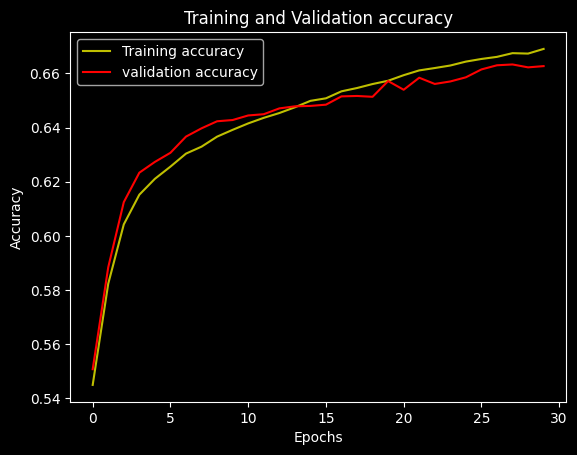

In [28]:
epochs = [i for i in range(len(accuracy_score_list_train))]
plt.plot(epochs, accuracy_score_list_train , 'y', label='Training accuracy')
plt.plot(epochs, accuracy_score_list_val, 'r', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4.1 Tuning the learning_rate

In [29]:
from sklearn.metrics import accuracy_score

accuracy_score_list_train_lr = dict()   ## accuracy score list of validation set 
accuracy_score_list_val_lr = dict()   ## accuracy score list of validation set 

for lr in [ 0.1 , 0.01 , 0.001 , 0.0001 ] :
    
    print("lr : " ,lr)
    skorch_model.set_params(lr= lr)
    skorch_model.fit(X_train_, y_train_)
    curr_epoch = skorch_model.history[-1]["epoch"]
    accuracy_score_list_train_lr[lr] = []
    accuracy_score_list_val_lr[lr] = []
    
    for i in range(20):
        
        curr_epoch+= 1 ## increment num of epochs

        skorch_model.partial_fit(X_train_, y_train_)  ## fir the model 

        y_train_pred_ = skorch_model.predict_proba(X_train_).argmax(axis=1) 
        y_val_pred_ = skorch_model.predict_proba(X_val_).argmax(axis=1)

        accuracy_score_list_train_lr[lr].append(accuracy_score(y_train_, y_train_pred_))
        accuracy_score_list_val_lr[lr].append(accuracy_score(y_val_, y_val_pred_))

        print("training score : ",accuracy_score(y_train_, y_train_pred_))
        print("validation score : ",accuracy_score(y_val_, y_val_pred_) )


lr :  0.1
Re-initializing module because the following parameters were re-set: num_classes, predictor.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss      dur
-------  ------------  -------
      1        0.9390  22.3894
      2        0.8058  22.1808
training score :  0.6439695669934641
validation score :  0.6387867647058824
      3        0.7799  21.0528
training score :  0.6339550142973857
validation score :  0.6282169117647058
      4        0.7673  21.7289
training score :  0.6643752553104575
validation score :  0.6565563725490197
      5        0.7562  20.8509
training score :  0.6557266135620915
validation score :  0.6545649509803921
      6        0.7491  20.7286
training score :  0.6691750919117647
validation score :  0.6596200980392157
      7        0.7440  22.2184
training score :  0.6666092218137255
validation score :  0.6597732843137255
      8        0.7382  26.6604
training score :  0.6750280841503268
validation score :  0.6674325980392157
 

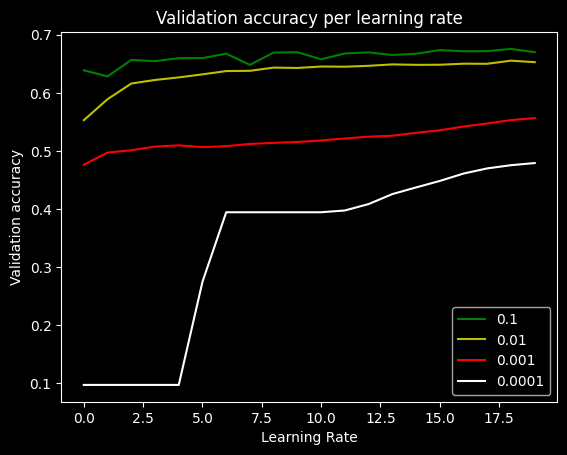

In [30]:
epochs = [i for i in range(len(accuracy_score_list_train_lr[0.01]))]

plt.plot(epochs, accuracy_score_list_val_lr[0.1], 'g', label='0.1')
plt.plot(epochs, accuracy_score_list_val_lr[0.01] , 'y', label='0.01')
plt.plot(epochs, accuracy_score_list_val_lr[0.001], 'r', label='0.001')
plt.plot(epochs, accuracy_score_list_val_lr[0.0001], 'w', label='0.0001')


plt.title('Validation accuracy per learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

We can see that a learning rate around 0.01 is very good , lower than that you would have slower convergence , we can also benefit from the fast learning of lr=0.1 , and have a scheduled learning rate that start around 0.1 and drop while training . 

### 4.2 Tuning Batch Size

In [36]:
from sklearn.metrics import accuracy_score

batch_sizes = [16, 32, 64, 128, 256, 512]

accuracy_score_list_train_bs = {}  ## accuracy score list of validation set 
accuracy_score_list_val_bs = {}   ## accuracy score list of validation set 

X_val_ = np.array(X_val).astype(np.float32)
y_val_ = np.array(val_targets).reshape(-1, 1)

skorch_model.set_params(lr = 0.03)
skorch_model.set_params(max_epochs = 1)
for batch_size in batch_sizes :
    
    print("batch_size : " ,batch_size)
    skorch_model.set_params(batch_size = batch_size)
    skorch_model.fit(X_train_, y_train_)
    k = 1
    curr_epoch = skorch_model.history[-1]["epoch"]
    accuracy_score_list_train_bs[batch_size] = []
    accuracy_score_list_val_bs[batch_size] = []
    
    for i in range(20):
        
        curr_epoch+= 1 ## increment num of epochs

        skorch_model.partial_fit(X_train_, y_train_)  ## fir the model 

        y_train_pred_ = skorch_model.predict_proba(X_train_).argmax(axis=1) 
        y_val_pred_ = skorch_model.predict_proba(X_val_).argmax(axis=1)

        accuracy_score_list_train_bs[batch_size].append(accuracy_score(y_train_, y_train_pred_))
        accuracy_score_list_val_bs[batch_size].append(accuracy_score(y_val_, y_val_pred_))

        print("training score : ",accuracy_score(y_train_, y_train_pred_))
        print("validation score : ",accuracy_score(y_val_, y_val_pred_) )

        k += 1 

batch_size :  16
Re-initializing module because the following parameters were re-set: num_classes, predictor.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss      dur
-------  ------------  -------
      1        0.8650  99.1276
      2        0.7764  87.3658
training score :  0.6561861723856209
validation score :  0.6559436274509803
      3        0.7597  88.5675
training score :  0.6704069648692811
validation score :  0.6628370098039216
      4        0.7490  101.8628
training score :  0.6728068831699346
validation score :  0.6639093137254902
      5        0.7418  84.5942
training score :  0.674038756127451
validation score :  0.6669730392156863
      6        0.7356  90.1488
training score :  0.6768407883986928
validation score :  0.6674325980392157
      7        0.7310  116.2965
training score :  0.6804087520424836
validation score :  0.6657475490196079
      8        0.7274  98.4500
training score :  0.6826427185457516
validation score :  0.6660539215

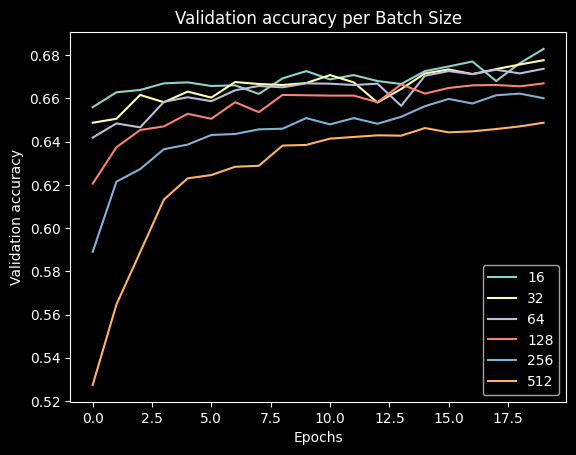

In [37]:
for bs, scores in accuracy_score_list_val_bs.items():
    epochs = range(len(scores))
    plt.plot(epochs, scores, label=str(bs))

plt.title("Validation accuracy per Batch Size")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()

4.3 Testing Different Optimizers

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score_list_train_op = {}   ## accuracy score list of validation set 
accuracy_score_list_val_op = {dict()}   ## accuracy score list of validation set 

X_val_ = np.array(X_val).astype(np.float32)
y_val_ = np.array(val_targets).reshape(-1, 1)

skorch_model.set_params(lr = 0.01 )
skorch_model.set_params(max_epochs = 1)
for optimizer in [ torch.optim.SGD , torch.optim.Adam , torch.optim.NAdam , RMSprop ] :
    
    print("optimizer : " ,optimizer)
    skorch_model.set_params(optimizer = optimizer)
    skorch_model.fit(X_train_, y_train_)
    k = 1
    curr_epoch = skorch_model.history[-1]["epoch"]
    accuracy_score_list_train_op[optimizer] = []
    accuracy_score_list_val_op[optimizer] = []
    
    for i in range(10):
        
        curr_epoch+= 1 ## increment num of epochs

        skorch_model.partial_fit(X_train_, y_train_)  ## fir the model 

        y_train_pred_ = skorch_model.predict_proba(X_train_).argmax(axis=1) 
        y_val_pred_ = skorch_model.predict_proba(X_val_).argmax(axis=1)

        accuracy_score_list_train_op[batch_size].append(accuracy_score(y_train_, y_train_pred_))
        accuracy_score_list_val_op[batch_size].append(accuracy_score(y_val_, y_val_pred_))

        print("training score : ",accuracy_score(y_train_, y_train_pred_))
        print("validation score : ",accuracy_score(y_val_, y_val_pred_) )

        k += 1 

In [ ]:
epochs = [i for i in range(len(accuracy_score_list_train[64]))]

plt.plot(epochs, accuracy_score_list_val_bs[16] , 'm', label='16')
plt.plot(epochs, accuracy_score_list_val_bs[32] , 'y', label='32')
plt.plot(epochs, accuracy_score_list_val_bs[64], 'r', label='64')
plt.plot(epochs, accuracy_score_list_val_bs[128], 'w', label='128')
plt.plot(epochs, accuracy_score_list_val_bs[256], 'g', label='256')
plt.plot(epochs, accuracy_score_list_val_bs[512], 'b', label='512')


plt.title('Validation accuracy per Batch Size')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

### 4.3 Training The Model

In [77]:
learning_rate = []
accuracy_score_list_train = []   ## accuracy score list of validation set 
accuracy_score_list_val = []   ## accuracy score list of validation set 
X_val_ = np.array(X_val).astype(np.float32)
y_val_ = np.array(val_targets).reshape(-1, 1)

## reset model from beginning 
skorch_model.set_params(lr= lr)
skorch_model.set_params( batch_size = 128)
skorch_model.fit(X_train_, y_train_) 

Re-initializing module because the following parameters were re-set: num_classes, predictor.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss      dur
-------  ------------  -------
      1        1.1029  32.1905


<class 'skorch.net.NeuralNet'>[initialized](
  module_=OrdinalLogisticModel(
    (predictor): Sequential(
      (0): Linear(in_features=3231, out_features=3231, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=3231, out_features=1, bias=False)
    )
    (link): LogisticCumulativeLink()
  ),
)

Here , we try each iterations manually , we start with High learning rate , and we drop it by time , we also save the learning rates history , and the different models we got at each epoch to return later to them

In [ ]:
from sklearn.metrics import accuracy_score
lr =  0.01

skorch_model.set_params(lr= lr)
skorch_model.set_params( batch_size = 128)  
k = 1 ## used to save model each 1 iteration
curr_epoch = skorch_model.history[-1]["epoch"] ## get current epoch

for i in range(5):
    
    learning_rate.append(lr) ## append lr to list of learning rate to visualize later 
    curr_epoch+= 1 ## increment num of epochs
    
    skorch_model.partial_fit(X_train_, y_train_)  ## fit the model 
    
    y_train_pred_ = skorch_model.predict_proba(X_train_).argmax(axis=1) 
    y_val_pred_ = skorch_model.predict_proba(X_val_).argmax(axis=1)
    
    accuracy_score_list_train.append(accuracy_score(y_train_, y_train_pred_))
    accuracy_score_list_val.append(accuracy_score(y_val_, y_val_pred_))
    
    print("training score : ",accuracy_score(y_train_, y_train_pred_))
    print("validation score : ",accuracy_score(y_val_, y_val_pred_) )
    
    ## Here we save the model each 1 iterations (can be changed) , to be able to get back to it later
    if ( k%1 == 0 and i >= 0 )  : 
        skorch_model.save_params(
        f_params='model_{}.pkl'.format(curr_epoch), f_optimizer='opt_{}.pkl'.format(curr_epoch), f_history='history.json')
        
    k += 1 

     84        0.5283  23.3963
training score :  0.7867774714052288
validation score :  0.6940870098039216
     85        0.5276  23.9031
training score :  0.7869115093954249
validation score :  0.6920955882352942
     86        0.5277  24.0892
training score :  0.7864966299019608
validation score :  0.6920955882352942
     87        0.5259  24.1278
training score :  0.7886986825980392
validation score :  0.6914828431372549
     88        0.5253  23.9715


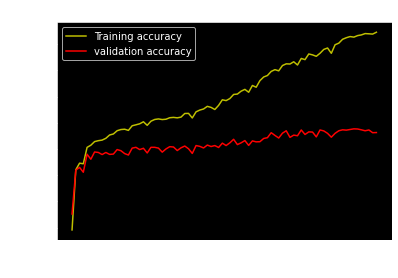

In [138]:
epochs = [i for i in range(len(accuracy_score_list_train))]
plt.plot(epochs, accuracy_score_list_train , 'y', label='Training accuracy')
plt.plot(epochs, accuracy_score_list_val, 'r', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Load the Model

In [ ]:
from skorch.callbacks import Checkpoint

new_skorch_model = NeuralNet(
    module=OrdinalLogisticModel,
    module__predictor=predictor,
    module__num_classes=num_classes,
    max_epochs= 1 ,
    optimizer=torch.optim.SGD,
    device = "cuda:0",
    
    criterion=CumulativeLinkLoss,
    train_split=None,
    iterator_train__shuffle=True,
    lr=0.01,
    callbacks=[
        ('ascension', AscensionCallback()  )      
    ],
)

new_skorch_model.initialize()  # This is important!
new_skorch_model.load_params(  ## load model 
    f_params='model_138.pkl', f_optimizer='opt_138.pkl', f_history='history.json')


Load Best Model

In [ ]:
new_skorch_model = NeuralNet(
    module=OrdinalLogisticModel,
    module__predictor=predictor,
    module__num_classes=num_classes,
    max_epochs= 1 ,
    optimizer=torch.optim.SGD,
    device = "cuda:0",
    
    criterion=CumulativeLinkLoss,
    train_split=None,
    iterator_train__shuffle=True,
    lr=0.01,
    callbacks=[
        ('ascension', AscensionCallback()  )       
    ],
)

new_skorch_model.initialize()  # This is important!
new_skorch_model.load_params( ## Load the Model
    f_params='model_138.pkl', f_optimizer='opt_138.pkl', f_history='history.json')


predict the output of the test data

In [ ]:
X_test_final_ = np.array(df_test[numeric_cols +encoded_cols]).astype(np.float32)
final_test_preds = skorch_model.predict(X_test_final_).argmax(axis=1)
reverse_mapping = {0:'Worst Concert Ever', 1:'Did Not Enjoy' , 2:'Enjoyed'  , 3:'Best Concert Ever' }
final_test_preds = [reverse_mapping[elt] for elt in final_test_preds]
df_test["Predicted"] = final_test_preds
df_test_final = df_test[["Id" , "Predicted"]]
df_test_final

In [ ]:
df_test_final.to_csv("final_12.csv" , index = False )

In [ ]:
X_test_ = np.array(X_test).astype(np.float32)
y_test_ = np.array(test_targets).reshape(-1, 1)
y_test_pred_ = new_skorch_model.predict_proba(X_test_).argmax(axis=1)

In [ ]:
accuracy_score(y_test_, y_test_pred_)